In [339]:
import sys 
sys.path.append("/Users/antonellacalvia/Desktop/ETH/NeuralPlanes")

In [1244]:
import cv2
import numpy as np 
import torch 
from matplotlib import pyplot as plt
from typing import Callable, List
from torch import nn
import functorch
from math import sqrt, ceil
from pomegranate.distributions import *

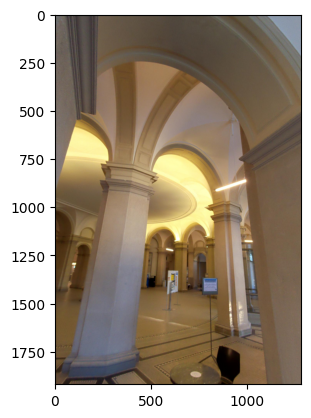

In [1177]:
img = cv2.imread("../../data/navvis_hg/raw_data/images_undistr_center/00110-cam1__center.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(float) / 255.0
plt.imshow(img)

torch.Size([1920]) torch.Size([1920, 3])


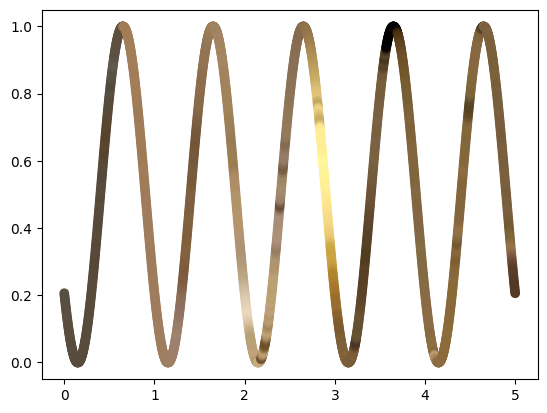

In [1236]:
height, width, c = img.shape 

z = torch.linspace(0, 5, height)
feature = torch.tensor(img[:,500])
occupancy = 0.5 + 0.5*torch.sin(2*torch.pi*(z - 0.4))

print(z.shape, feature.shape)

plt.scatter(z, occupancy, c=feature)

In [860]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super(PositionalEncoding, self).__init__()

        self.d_model = d_model
        self.alpha = nn.Parameter(torch.tensor(1.0))

    def forward(self, x, z, model_first=False):
        """
        Args:
            x: Tensor of shape (batch_size, d_model), or (d_model,batch_size)
            z: Tensor of shape (batch_size), or (x,y)
        """

        d_model = self.d_model
        d_model_round = d_model + (d_model%2)
        div_term = torch.exp(torch.arange(0, d_model, 2, device=x.device)).float() #* (-torch.log(torch.tensor(10000.0)) / d_model)

        if model_first:
            pe = torch.zeros((d_model, x.shape[1]), device=x.device)

            a = torch.sin(z * div_term[:,None]) # (d_model//2,batch_size)
            b = torch.cos(z * div_term[:,None]) # (d_model//2,batch_size)
            pe = torch.stack((a,b), dim=1) # (d_model//2,2,batch_size)
            pe = pe.reshape(d_model_round, pe.shape[2])[:d_model]
        else: 
            pe = torch.zeros((len(x), d_model), device=x.device)
            a = torch.sin(z[:,None] * div_term[None,:])
            b = torch.cos(z[:,None] * div_term[None,:])
            pe = torch.stack((a,b), dim=0)
            pe = pe.reshape(x.shape[0], d_model_round)[:,:d_model]

        x = x + torch.sigmoid(self.alpha) * pe
        return x
    
PositionalEncoding(3)(torch.zeros(10,3), torch.zeros(10))

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311]], grad_fn=<AddBackward0>)

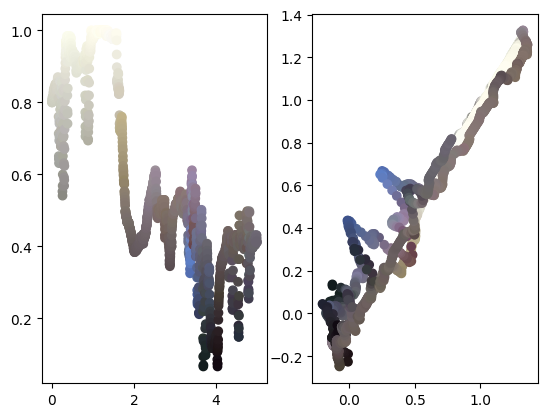

In [898]:
positional = PositionalEncoding(3)
feature_pos = positional(feature / torch.linalg.norm(feature,dim=1,keepdim=True), z)

feature_pos = feature_pos.detach()

plt.subplot(121)
plt.scatter(z, feature[:,0], c=feature)

plt.subplot(122)
plt.scatter(feature_pos[:,0], feature_pos[:,2], c=feature)

In [1063]:
class GaussianCluster:
    mu: torch.Tensor 
    var: torch.Tensor 
    features: torch.Tensor
    dist_fn: Callable[[torch.Tensor], torch.Tensor]

    reduction: str 
    initialized: bool
    num_components: int 

    eps: float

    def __init__(self, num_components, dist: str = 'l2', reduction = 'avg', eps = 1e-6):
        l2_dist = lambda x,y,dim: torch.linalg.norm(x-y,dim=dim)
        cos_dist = lambda x,y,dim: 1-torch.maximum(torch.cosine_similarity(x,y,dim=dim), torch.tensor(0.,device=x.device))

        if dist == 'l2':
            dist_fn = l2_dist
        elif dist == 'cos':
            dist_fn = cos_dist
        else:
            raise NotImplemented()
        
        self.num_components = num_components
        self.reduction = reduction
        self.dist_fn = dist_fn
        self.initialized = False
        self.eps = eps

    def _sample(self, mu, var, features, z_in):
        eps = self.eps 

        kernel = torch.exp(-(z_in[None, :] - mu[:,None])**2 / var[:,None])
        weight = kernel.sum(dim=0)
        kernel_norm = kernel / (eps + weight[None,:])
        features_interp = (features[:,None] * kernel_norm[:,:,None]).sum(dim=0)
        return features_interp

    def sample(self, z_in):
        return self._sample(self.mu, self.var, self.features, z_in)

    def _loss(self, mu, var, features, z_in, importance_in, features_in):
        dist, eps = self.dist_fn, self.eps
        
        kernel = torch.exp(-(z_in[None, :] - mu[:,None])**2 / var[:,None])
        weight = kernel.sum(dim=0)
        kernel_norm = kernel / (eps + weight[None,:])
        weight_norm = weight / (eps + weight.sum())

        features_interp = (features[:,None] * kernel_norm[:,:,None]).sum(dim=0)
        importance_norm = importance_in / (eps + importance_in.sum())

        loss_feature = (importance_norm * dist(features_in, features_interp, dim=1)).sum()
        loss_density = -1e-2 * (importance_norm * torch.log(weight_norm)).sum()

        return loss_feature + loss_density
    
    def loss(self, z_in, importance_in, features_in):
        mu, var, features = self.mu, self.var, self.features
        return self._loss(mu, var, features, z_in, importance_in, features_in)

    def init(self, z_in, importance_in, features_in):
        num_components = self.num_components

        initial = torch.multinomial(importance_in.reshape(num_components, len(features_in)//num_components), num_samples=1)
        initial = (len(features_in)//num_components) * torch.arange(num_components) + initial.flatten()

        features = features_in[initial]
        mu = z_in[initial]

        var = torch.full_like(mu, 0.5)

        self.features = nn.Parameter(features)
        self.mu = nn.Parameter(mu)
        self.var = nn.Parameter(var)
        self.initialized = True

    def assign_features(self, z_in, importance_in, features_in,):
        mu, var, reduction = self.mu, self.var, self.reduction

        kernel = torch.exp(-((z_in[None, :] - mu[:,None]))**2 / var[:,None])
        
        if reduction == 'max':
            assignment = torch.softmax(5*kernel, dim=0)
            mask = assignment > 0.8
            features_masked = torch.where(mask[:,:,None], features_in[None], torch.tensor(0., device=mu.device))
            features = features_masked.max(dim=1)[0]
        elif reduction == 'avg':
            kernel = kernel / (1e-9 + kernel.sum(dim=1, keepdim=True))
            features = (kernel[:,:,None] * features_in[None]).sum(dim=1)
        elif reduction == 'none':
            pass
        else:
            raise NotImplemented()
        
        self.features = features

    def fit(self, z_in, importance_in, features_in, n_steps=30, lr = 1e-1):
        if not self.initialized:
            self.init(z_in, importance_in, features_in)

        mu, var = self.mu, self.var

        loss_fn = functorch.grad_and_value(self._loss, argnums=(0,1))

        for i in range(n_steps):
            self.assign_features(z_in, importance_in, features_in)
            grad, loss = loss_fn(mu, var, self.features, z_in, importance_in, features_in)
            mu = mu - lr * grad[0]
            var = var - lr * grad[1]

        self.assign_features(z_in, importance_in, features_in)
        
        return self
    
GaussianCluster(num_components=5, reduction='avg', dist='cos').fit(z, occupancy, feature)

/Users/antonellacalvia/Desktop/ETH/NeuralPlanes/.venv/lib/python3.9/site-packages/torch/_functorch/deprecated.py:69: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad_and_value is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad_and_value instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('grad_and_value')


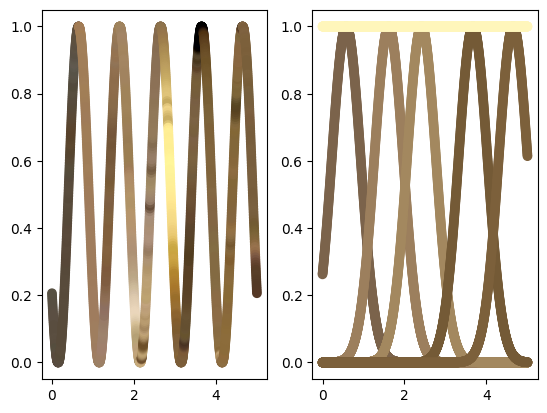

In [1237]:
feature_norm = feature #/ torch.linalg.norm(feature, dim=1, keepdim=True)
cluster = GaussianCluster(num_components=5, reduction='avg', dist='cos').fit(z, occupancy, feature_norm)
mu, var, features = cluster.mu, cluster.var, cluster.features

plt.subplot(121)
plt.scatter(z,occupancy,c=feature_norm)

plt.subplot(122)
for j in range(cluster.num_components):
    plt.scatter(z, torch.exp(-((z-mu[j])/var[j])**2).detach(), c=features[j].repeat(len(z),1).detach())

color = torch.max(feature_norm, dim=0)[0]
plt.scatter(z, torch.ones_like(z), c=color[None].repeat(len(z),1))

In [1152]:
import torch
from transformers import AutoImageProcessor, AutoBackbone
import torchvision

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
out_features = ["stage2", "stage5", "stage8", "stage11"]
model = AutoBackbone.from_pretrained("facebook/dinov2-base", out_features=out_features)

def embed_images(images):
    inputs = processor(images=images, return_tensors="pt")
    outputs = model(**inputs)
    
    feature_maps = outputs.feature_maps # torch.Size([1, 3072, 16, 16])
    embed = torch.cat(feature_maps, dim=1)
    print(embed.shape)
    return embed

embed_images(img).shape

torch.Size([1, 3072, 16, 16])


torch.Size([1, 3072, 16, 16])

In [ ]:
use_embeddings = True
if use_embeddings:
    img_small = embed_images(img)[0]
    img_small = nn.functional.interpolate(img_small[None], (64,64))[0]
    img_small = img_small.permute(1,2,0)
else:
    img_small = torch.tensor(cv2.resize(img, (500,500)))

height,width,c = img_small.shape 

ref = 15
z = torch.linspace(0, 5, height)
feature = torch.tensor(img_small[:,ref])
print(feature.shape, z.shape)
occupancy = torch.ones_like(z) #0.5 + 0.5*torch.sin(2*torch.pi*(z - 0.4))

default_config = {'num_components': 4}

configs = [
    {'reduction': 'max', 'dist': 'l2', 'norm': False},
    {'reduction': 'avg', 'dist': 'l2', 'norm': False},
    {'reduction': 'max', 'dist': 'l2', 'norm': True},
    {'reduction': 'avg', 'dist': 'l2', 'norm': True},
    {'reduction': 'max', 'dist': 'cos', 'norm': True},
    {'reduction': 'avg', 'dist': 'cos', 'norm': True},
]

methods = [
    {
        'name': "cluster",
        
    }
]

torch.Size([1, 3072, 16, 16])
torch.Size([64, 3072]) torch.Size([64])


/var/folders/7f/hqfn5gpn4437qnrwr51sm1n00000gn/T/ipykernel_34380/584062753.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(img_small[:,ref])
/Users/antonellacalvia/Desktop/ETH/NeuralPlanes/.venv/lib/python3.9/site-packages/torch/_functorch/deprecated.py:69: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.grad_and_value is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.grad_and_value instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('grad_and_value')


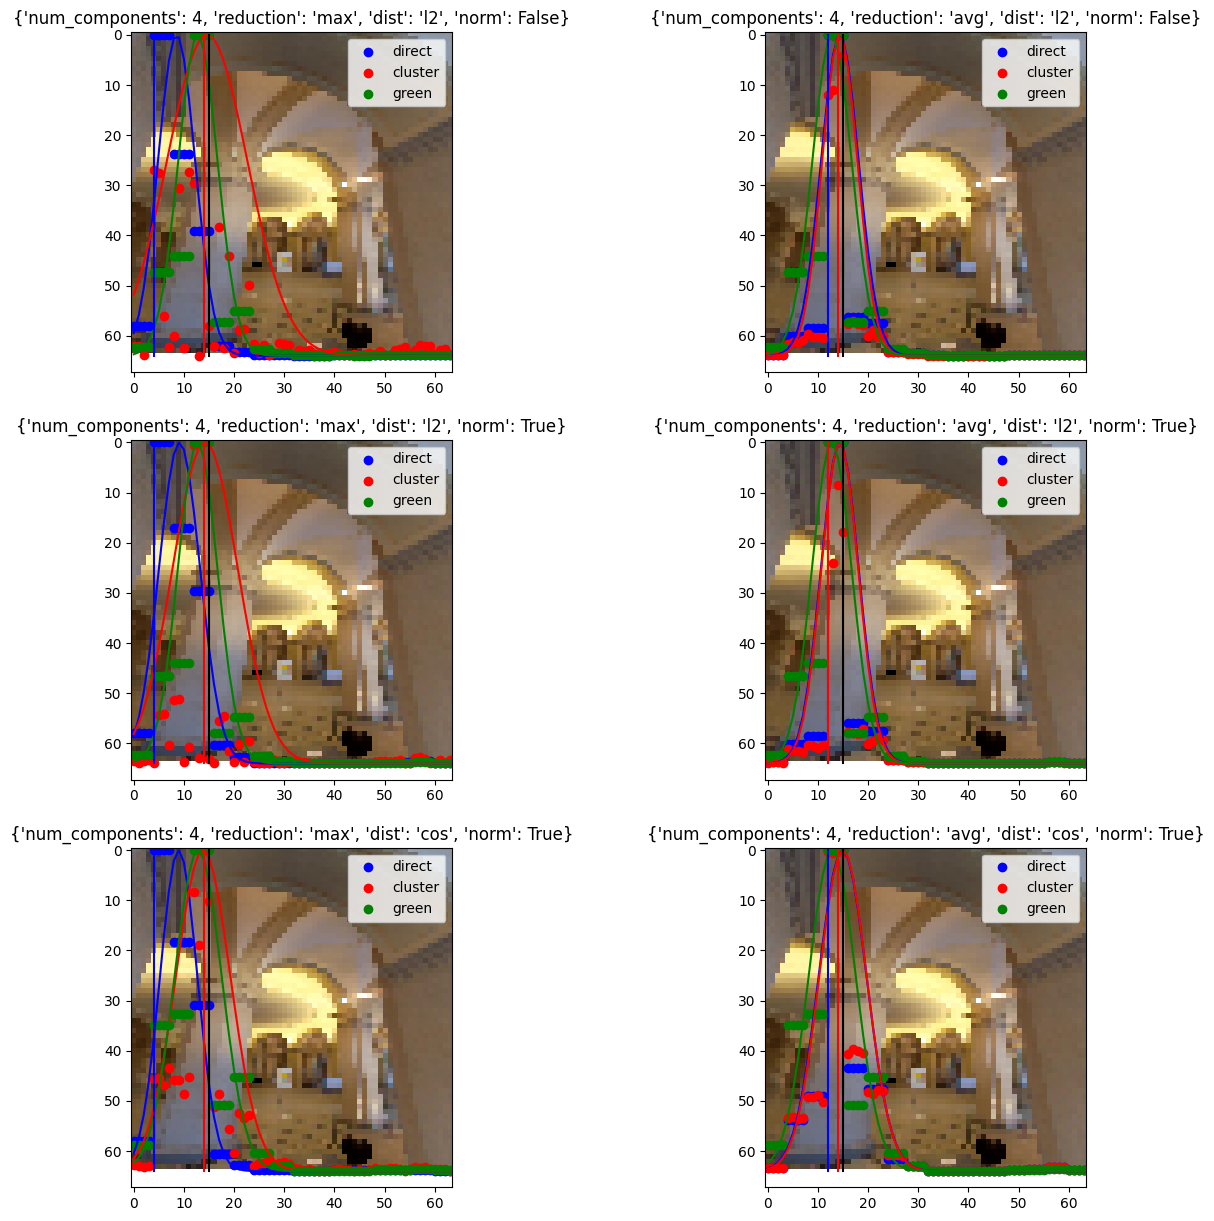

In [1240]:
use_embeddings = True
if use_embeddings:
    img_small = embed_images(img)[0]
    img_small = nn.functional.interpolate(img_small[None], (64,64))[0]
    img_small = img_small.permute(1,2,0)
else:
    img_small = torch.tensor(cv2.resize(img, (500,500)))

height,width,c = img_small.shape 

ref = 15
z = torch.linspace(0, 5, height)
feature = torch.tensor(img_small[:,ref])
print(feature.shape, z.shape)
occupancy = torch.ones_like(z) #0.5 + 0.5*torch.sin(2*torch.pi*(z - 0.4))

default_config = {'num_components': 4}

configs = [
    {'reduction': 'max', 'dist': 'l2', 'norm': False},
    {'reduction': 'avg', 'dist': 'l2', 'norm': False},
    {'reduction': 'max', 'dist': 'l2', 'norm': True},
    {'reduction': 'avg', 'dist': 'l2', 'norm': True},
    {'reduction': 'max', 'dist': 'cos', 'norm': True},
    {'reduction': 'avg', 'dist': 'cos', 'norm': True},
]

n = len(configs)
grid_width = int(sqrt(n))
grid_height = int(ceil(n / grid_width))
fig, axes = plt.subplots(grid_height, grid_width)
axes = axes.flat
fig.set_figheight(15)
fig.set_figwidth(15)

mask_half = True
if mask_half:
    z_mask = z[height//2:]
    occupancy_mask = occupancy[height//2:]
    img_small_mask = img_small[height//2:]
else:
    z_mask,occupancy_mask,img_small_mask = z, occupancy, img_small

results = []

for ax, config in zip(axes, configs):
    config = {**default_config, **config}
    feature_norm = feature 

    def norm(x):
        if config['norm']:
            return x / (1e-9 + torch.linalg.norm(x,dim=1, keepdim=True))
        else:
            return x

    cluster = GaussianCluster(num_components=config['num_components'], reduction=config['reduction'], dist=config['dist']).fit(z, occupancy, norm(feature))

    def score_direct(column):
        loss = cluster.loss(z_mask, occupancy_mask, norm(column))
        return loss
    
    def score_cluster(column):
        cluster_col = GaussianCluster(num_components=config['num_components'], reduction=config['reduction'], dist=config['dist']).fit(z_mask, occupancy_mask, norm(column))
        feature = cluster_col.sample(z_mask)
        return cluster.loss(z_mask, occupancy_mask, feature)
    
    def score_reduce(column):
        ref_feature = norm(img_small[:,ref]).max(dim=0)[0]
        col_feature = norm(column).max(dim=0)[0]
        return cluster.dist_fn(ref_feature,col_feature,dim=0)
    
    def summarize(scores):
        scores = (scores - scores.min()) / (scores.max() - scores.min())
        scores = torch.exp(-8*scores)
        dist = Normal().fit(xs[:,None], sample_weight = scores)
        return scores, { "mean": dist.means[0], "cov": dist.covs[0] }

    def plot_dist(name, dist, summary, color):
        ax.scatter(xs, height * (1 - dist), label=name, color=color)

        mean, cov = summary["mean"], summary["cov"]
        fit = torch.exp(-(xs - mean)**2 / cov)

        ax.plot(xs, height * (1 - fit), color=color)

    img_cols = img_small_mask.permute(1,0,2)

    xs = torch.arange(len(img_cols))
    ys = torch.vmap(score_direct)(img_cols).detach()
    ys2 = torch.vmap(score_cluster, randomness='different')(img_cols).detach()
    ys3 = torch.vmap(score_reduce)(img_cols).detach()

    ys, s = summarize(ys)
    ys2, s2 = summarize(ys2)
    ys3, s3 = summarize(ys3)

    results.append({"direct": s, "cluster": s2, "red": s3})

    loc = ys.argmax()
    loc2 = ys2.argmax()

    ax.title.set_text(str(config))
    ax.imshow(cv2.resize(img, (height,width)))

    plot_dist('direct', ys, s, 'blue')
    plot_dist('cluster', ys2, s2, 'red')
    plot_dist('green', ys3, s3, 'green')

    ax.plot([loc, loc], [0, height], color='blue')
    ax.plot([loc2, loc2], [0, height], color='red')
    #ax.plot([xs.min(), xs.max()], [ys[ref],ys[ref]])
    ax.plot([ref,ref], [0, height], color='black')
    ax.legend()

In [1242]:
import pprint
pprint.pprint(list(zip(map(str, configs), results)))

[("{'reduction': 'max', 'dist': 'l2', 'norm': False}",
  {'cluster': {'cov': tensor([129.1366]), 'mean': tensor(14.6310)},
   'direct': {'cov': tensor([27.4797]), 'mean': tensor(8.5368)},
   'red': {'cov': tensor([30.7392]), 'mean': tensor(12.7898)}}),
 ("{'reduction': 'avg', 'dist': 'l2', 'norm': False}",
  {'cluster': {'cov': tensor([24.8238]), 'mean': tensor(14.3490)},
   'direct': {'cov': tensor([28.1143]), 'mean': tensor(14.3533)},
   'red': {'cov': tensor([30.7392]), 'mean': tensor(12.7898)}}),
 ("{'reduction': 'max', 'dist': 'l2', 'norm': True}",
  {'cluster': {'cov': tensor([84.9503]), 'mean': tensor(14.2365)},
   'direct': {'cov': tensor([33.7756]), 'mean': tensor(9.1276)},
   'red': {'cov': tensor([31.2426]), 'mean': tensor(12.7425)}}),
 ("{'reduction': 'avg', 'dist': 'l2', 'norm': True}",
  {'cluster': {'cov': tensor([27.0716]), 'mean': tensor(14.3495)},
   'direct': {'cov': tensor([28.3265]), 'mean': tensor(14.3468)},
   'red': {'cov': tensor([31.2426]), 'mean': tensor(12.7

15


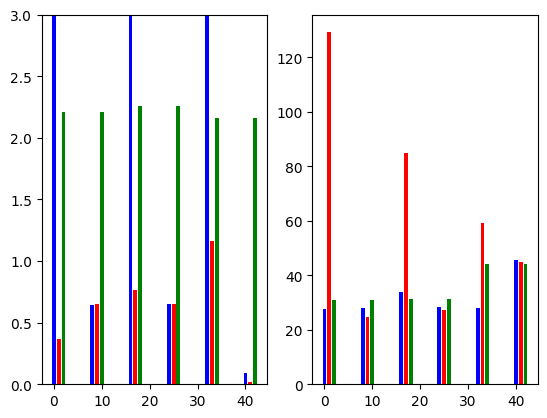

In [1241]:
print(ref)
methods = {}
colors = {"direct": 'blue', 'cluster': 'red', 'red': 'green'}

fig, (ax_dist, ax_cov) = plt.subplots(1,2)

ax_dist.set_ylim(0,3)

i = 0
for config, result in zip(configs, results):
    for name, method_result in result.items():
        diff = abs(method_result['mean']-ref)
        color = colors[name]
        ax_dist.bar(i, diff, color=color)
        ax_cov.bar(i, method_result['cov'], color=color)

        i += 1

    i += 5

In [ ]:
# Conclusion cluster with l2-norm is best

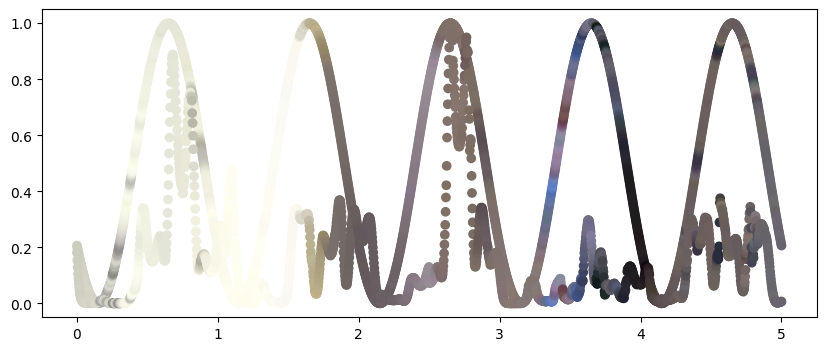

In [928]:
import pomegranate.gmm as gmm
from pomegranate.distributions import *

X = feature_pos
#torch.cat([z[:,None], feature], dim=1)
#feature_pos
#torch.cat([z[:,None], feature], dim=1)

model = gmm.GeneralMixtureModel([Normal(covariance_type='diag') for i in range(5)]).fit(X, sample_weight=occupancy)

#assignment = model.predict_proba(X)
#score = assignment #* (X-model.)
#p = assignment.max(dim=1)[0]
p = model.probability(X)
p = p / p.max()

#.predict_proba(X) #.reshape(len(x), len(y))
#p = p.max(dim=1)[0]
plt.figure(figsize=(10, 4))
plt.subplot(111)
plt.scatter(z, occupancy, c=feature)
plt.scatter(z, p, c=feature)


In [ ]:


def sample_image(conf: NeuralMapConf):


    fp = frustum_points(cam)

    origin = planes_x0s + u[:, :, None] * planes_us + v[:, :, None] * planes_vs
    dir = planes_planes.repeat((height, width, 1))
    origin, dir = origin.reshape((-1, 3)), dir.reshape((-1, 3))

    tmin, tmax = frustum_ray_intersection(fp, origin, dir)
    mask = torch.isfinite(tmin)

    start = origin.reshape((-1, 3)) + tmin[:, None] * dir.reshape((-1, 3))
    end = origin.reshape((-1, 3)) + tmax[:, None] * dir.reshape((-1, 3))

    length = conf.column_sampling_density * torch.max(torch.cat([torch.linalg.norm(end - start, dim=1)[mask], torch.zeros(1,device=device)]))
    length = int(ceil(length))

    def get_sample_coords(tsample):
        tsample = tmin[:,None] * (1 - tsample) + tmax[:,None] * tsample
        pos = (origin[:,None] + tsample[:,:,None] * dir[:,None])
        proj = cam.to_image_space(pos.reshape(-1,3)).reshape((height*width,tsample.shape[1],3))
        sample_coords = 2 * (proj[:,:,0:2] / torch.tensor([img_width+1, img_height+1],device=device)) - img_width/(img_width+1)
        return sample_coords, proj[:,:,2], pos

    def sample_linear_pdf(u, x0, x1, d):
        return d * (-x0 + torch.sqrt(x0 ** 2 + (x1 ** 2 - x0 ** 2) * u)) / (x1 - x0 + 1e-9)

    def depth_to_occupancy(depth, depth_values):
        depth_sigma = depth_values * self.conf.depth_sigma # 1.0 / (math.sqrt(2 * math.pi) * depth_sigma) *

        occupancy = torch.exp(-0.5 * ((depth - depth_values) / depth_sigma) ** 2) #1.0 / (math.sqrt(2 * math.pi) * depth_sigma) *
        return torch.where(mask[:,None], occupancy, torch.tensor(0,device=device))

    depth_distribution_samples = self.conf.depth_distribution_samples
    depth_sample_coords, depth, _ = get_sample_coords(torch.linspace(0,1,depth_distribution_samples,device=device)[None,:])
    depth_values = torch.nn.functional.grid_sample(input_depth[None, None], depth_sample_coords[None,:,:,0:2])[0, 0]
    occupancy = depth_to_occupancy(depth, depth_values)

    # sample based on linear pdf
    tsample_index = torch.multinomial(occupancy+1e-9, num_samples=length, replacement= length > self.conf.depth_distribution_samples)
    tsample = torch.rand_like(tsample_index,dtype=torch.float)

    x0 = torch.gather(depth_values, 1, tsample_index)
    limit = torch.tensor(self.conf.depth_distribution_samples-1, device=device).unsqueeze(0)
    x1 = torch.gather(depth_values, 1, torch.minimum(tsample_index+1, limit))

    delta = 1.0/(depth_distribution_samples-1)
    tsample = tsample_index*delta + sample_linear_pdf(tsample, x0, x1, delta)

    sample_coords, depth, pos = get_sample_coords(tsample)
    image_values = torch.nn.functional.grid_sample(input_image[None], sample_coords[None])[0]
    depth_values = torch.nn.functional.grid_sample(input_depth[None,None], sample_coords[None])[0,0]
    
    occupancy = depth_to_occupancy(depth, depth_values)

    #depth = depth.reshape((height,width,length))
    occupancy = occupancy.reshape((height,width,length))
    image_values = image_values.reshape((c, height, width, length))
    depth_values = depth_values.reshape((height, width, length))
    tsample = tsample.reshape((height, width, length))
    pos = pos.reshape((height, width, length, 3))
    mask = torch.isfinite(tsample)
    tsample = tsample.reshape((height,width,length))

